In [4]:
import os
import subprocess
from nipype.interfaces import fsl

# FSL 환경 설정
os.environ['FSLDIR'] = '/home/minyoungxi/fsl'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')

# 한 명의 환자

In [3]:
import os
import nibabel as nib
import numpy as np
import torch
from nipype.interfaces import fsl
import subprocess

def run_mcflirt(in_file, out_file):
    mcflirt = fsl.MCFLIRT(in_file=in_file, out_file=out_file, save_plots=True)
    return mcflirt.run()

def run_slicetimer(in_file, out_file):
    slicetimer = fsl.SliceTimer(in_file=in_file, out_file=out_file)
    return slicetimer.run()

def run_smooth(in_file, out_file, fwhm=2):
    smooth = fsl.maths.IsotropicSmooth(in_file=in_file, fwhm=fwhm, out_file=out_file)
    return smooth.run()

def run_highpass(in_file, out_file, highpass_sigma=50):
    highpass = fsl.TemporalFilter(in_file=in_file, highpass_sigma=highpass_sigma, out_file=out_file)
    return highpass.run()

def run_bet(in_file, out_file):
    bet = fsl.BET(in_file=in_file, out_file=out_file, frac=0.3)
    return bet.run()

def run_flirt(in_file, ref_file, out_file, out_matrix_file, dof=6):
    flirt = fsl.FLIRT()
    flirt.inputs.in_file = in_file
    flirt.inputs.reference = ref_file
    flirt.inputs.out_file = out_file
    flirt.inputs.out_matrix_file = out_matrix_file
    flirt.inputs.dof = dof
    flirt.inputs.cost = 'corratio' 
    result = flirt.run()
    print(f"FLIRT command: {result.runtime.cmdline}")
    print(f"FLIRT stdout: {result.runtime.stdout}")
    print(f"FLIRT stderr: {result.runtime.stderr}")
    return result

def apply_xfm(in_file, ref_file, out_file, matrix_file):
    apply_xfm = fsl.ApplyXFM()
    apply_xfm.inputs.in_file = in_file
    apply_xfm.inputs.reference = ref_file
    apply_xfm.inputs.out_file = out_file
    apply_xfm.inputs.in_matrix_file = matrix_file
    apply_xfm.inputs.apply_xfm = True
    return apply_xfm.run()

def create_mean_img(in_file, out_file):
    img = nib.load(in_file)
    mean_data = np.mean(img.get_fdata(), axis=3)
    mean_img = nib.Nifti1Image(mean_data, img.affine, img.header)
    nib.save(mean_img, out_file)
    return out_file

def run_fsl_command(command):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    stdout, stderr = process.communicate()
    print(f"Command: {command}")
    print(f"Stdout: {stdout.decode()}")
    print(f"Stderr: {stderr.decode()}")

def preprocess_fmri(func_file, struct_file, standard_file, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Motion Correction
    mcflirt_output = os.path.join(output_dir, "mcflirt_output.nii.gz")
    run_mcflirt(func_file, mcflirt_output)

    # Slice Timing Correction
    slicetimer_output = os.path.join(output_dir, "slicetimer_output.nii.gz")
    run_slicetimer(mcflirt_output, slicetimer_output)

    # Spatial Smoothing
    smooth_output = os.path.join(output_dir, "smooth_output.nii.gz")
    run_smooth(slicetimer_output, smooth_output)

    # Temporal Filtering
    highpass_output = os.path.join(output_dir, "highpass_output.nii.gz")
    run_highpass(smooth_output, highpass_output)

    # Create mean functional image
    mean_func_output = os.path.join(output_dir, "mean_func.nii.gz")
    create_mean_img(highpass_output, mean_func_output)

    # Brain Extraction on structural image
    bet_output = os.path.join(output_dir, "bet_output.nii.gz")
    run_bet(struct_file, bet_output)

    # Registration of mean functional to structural
    func_to_struct_output = os.path.join(output_dir, "func_to_struct.nii.gz")
    func_to_struct_mat = os.path.join(output_dir, "func_to_struct.mat")
    run_flirt(mean_func_output, bet_output, func_to_struct_output, func_to_struct_mat, dof=6)
    
    if not os.path.exists(func_to_struct_mat):
        print("Matrix file not found. Trying to run FLIRT directly...")
        run_fsl_command(f"flirt -in {mean_func_output} -ref {bet_output} -out {func_to_struct_output} -omat {func_to_struct_mat} -dof 6")
    
    if not os.path.exists(func_to_struct_mat):
        raise FileNotFoundError(f"Expected matrix file {func_to_struct_mat} was not created by FLIRT.")

    struct_to_mni_output = os.path.join(output_dir, "struct_to_mni.nii.gz")
    struct_to_mni_mat = os.path.join(output_dir, "struct_to_mni.mat")
    run_flirt(bet_output, standard_file, struct_to_mni_output, struct_to_mni_mat, dof=12)
    
    if not os.path.exists(struct_to_mni_mat):
        print("Matrix file not found. Trying to run FLIRT directly...")
        run_fsl_command(f"flirt -in {bet_output} -ref {standard_file} -out {struct_to_mni_output} -omat {struct_to_mni_mat} -dof 12")
    
    if not os.path.exists(struct_to_mni_mat):
        raise FileNotFoundError(f"Expected matrix file {struct_to_mni_mat} was not created by FLIRT.")

    combined_mat = os.path.join(output_dir, "func_to_mni.mat")
    fsl.ConvertXFM(concat_xfm=True, in_file=func_to_struct_mat, in_file2=struct_to_mni_mat, out_file=combined_mat).run()

    mni_output = os.path.join(output_dir, "mni_output.nii.gz")
    apply_xfm(highpass_output, standard_file, mni_output, combined_mat)

    return mni_output

func_file = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/func2/NIFTI/sub-OAS30011_ses-d0055_task-rest_run-02_bold.nii.gz"
struct_file = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/anat2/NIFTI/sub-OAS30011_ses-d0055_T1w.nii.gz"
standard_file = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz')
output_dir = "/home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed"

print(f"FSLDIR: {os.environ.get('FSLDIR')}")
print(f"PATH: {os.environ.get('PATH')}")

print(f"Func file exists: {os.path.exists(func_file)}")
print(f"Struct file exists: {os.path.exists(struct_file)}")
print(f"Standard file exists: {os.path.exists(standard_file)}")

final_output = preprocess_fmri(func_file, struct_file, standard_file, output_dir)

preprocessed_data = nib.load(final_output).get_fdata()
preprocessed_tensor = torch.from_numpy(preprocessed_data).float()

print(f"Final output exists: {os.path.exists(final_output)}")
print(f"Original functional data shape: {nib.load(func_file).shape}")
print(f"Preprocessed MNI data shape: {preprocessed_data.shape}")
print(f"Preprocessed tensor shape: {preprocessed_tensor.shape}")

FSLDIR: /home/minyoungxi/fsl
PATH: /home/minyoungxi/anaconda3/envs/TorchEnv/bin:/home/minyoungxi/fsl/share/fsl/bin:/home/minyoungxi/fsl/share/fsl/bin:/home/minyoungxi/.local/bin:/home/minyoungxi/gems/bin:/home/minyoungxi/anaconda3/envs/TorchEnv/bin:/home/minyoungxi/anaconda3/condabin:/usr/local/cuda/bin:/home/minyoungxi/fsl/share/fsl/bin:/home/minyoungxi/fsl/share/fsl/bin:/home/minyoungxi/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin:/usr/bin/obsidian:/usr/bin/obsidian
Func file exists: True
Struct file exists: True
Standard file exists: True
FLIRT command: flirt -in /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/mean_func.nii.gz -ref /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/bet_output.nii.gz -out /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/func_to_struct.nii.gz -omat /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/func_to_struct.mat -cost corratio -dof 6
FLIRT stdout: 
FLIRT stderr: 
FLIRT co

/tmp/ipykernel_1339297/4196462968.py:49: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()


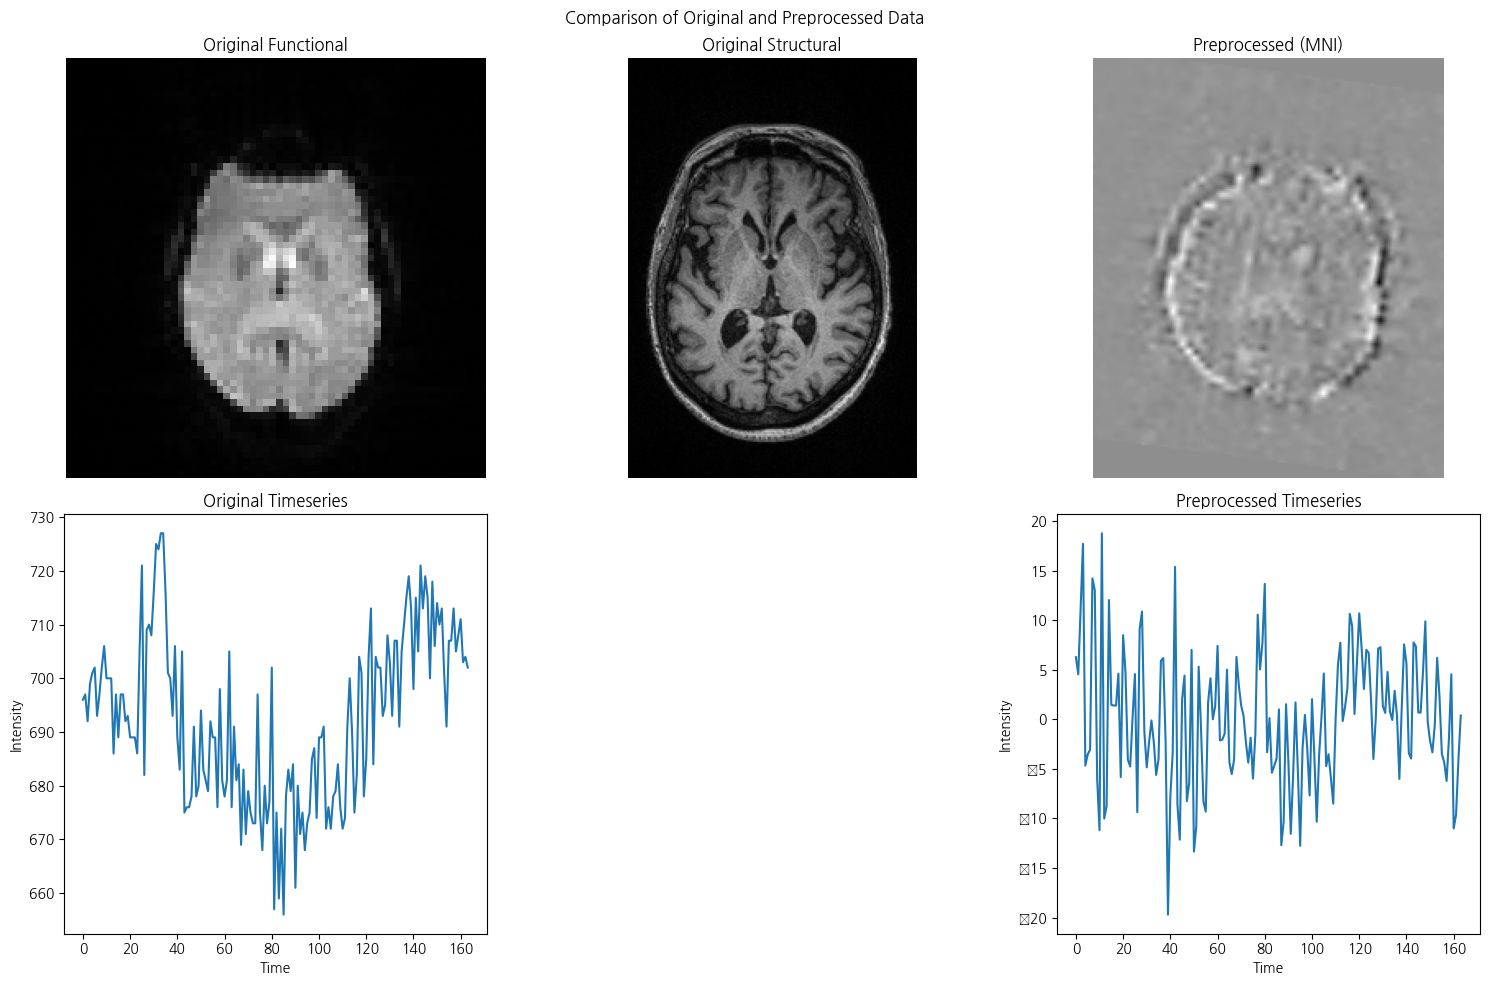

Original functional data shape: (64, 64, 36, 164)
Original structural data shape: (176, 256, 256)
Preprocessed data shape: (182, 218, 182, 164)
Original functional data range: 0.0 to 1284.0
Preprocessed data range: -297.2989501953125 to 300.0141296386719


In [4]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

def plot_slice(ax, data, title):
    if data.ndim == 4:
        mid_time = data.shape[3] // 2
        slice_data = data[:, :, data.shape[2]//2, mid_time]
    else:
        slice_data = data[:, :, data.shape[2]//2]
    ax.imshow(slice_data.T, cmap='gray', origin='lower')
    ax.set_title(title)
    ax.axis('off')

def plot_timeseries(ax, data, title):
    if data.ndim == 4:
        center = tuple(s // 2 for s in data.shape[:3])
        timeseries = data[center[0], center[1], center[2], :]
        ax.plot(timeseries)
        ax.set_title(title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Intensity')

# 원본 데이터 로드
orig_func_img = nib.load(func_file)
orig_func_data = orig_func_img.get_fdata()

orig_struct_img = nib.load(struct_file)
orig_struct_data = orig_struct_img.get_fdata()

# 전처리된 데이터 로드
preprocessed_img = nib.load(final_output)
preprocessed_data = preprocessed_img.get_fdata()

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Comparison of Original and Preprocessed Data')

plot_slice(axes[0, 0], orig_func_data, 'Original Functional')
plot_slice(axes[0, 1], orig_struct_data, 'Original Structural')
plot_slice(axes[0, 2], preprocessed_data, 'Preprocessed (MNI)')

plot_timeseries(axes[1, 0], orig_func_data, 'Original Timeseries')
plot_timeseries(axes[1, 2], preprocessed_data, 'Preprocessed Timeseries')

# 구조적 이미지는 시계열이 없으므로 해당 축은 비워둡니다
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# 데이터 형태 출력
print(f"Original functional data shape: {orig_func_data.shape}")
print(f"Original structural data shape: {orig_struct_data.shape}")
print(f"Preprocessed data shape: {preprocessed_data.shape}")

# 데이터 값 범위 출력
print(f"Original functional data range: {orig_func_data.min()} to {orig_func_data.max()}")
print(f"Preprocessed data range: {preprocessed_data.min()} to {preprocessed_data.max()}")

# 전체 파이프라인 

In [1]:
import os
import nibabel as nib
import numpy as np
import torch
from nipype.interfaces import fsl
import subprocess
import glob
import re

def run_mcflirt(in_file, out_file):
    mcflirt = fsl.MCFLIRT(in_file=in_file, out_file=out_file, save_plots=True)
    return mcflirt.run()

def run_slicetimer(in_file, out_file):
    slicetimer = fsl.SliceTimer(in_file=in_file, out_file=out_file)
    return slicetimer.run()

def run_smooth(in_file, out_file, fwhm=5):
    smooth = fsl.maths.IsotropicSmooth(in_file=in_file, fwhm=fwhm, out_file=out_file)
    return smooth.run()

def run_highpass(in_file, out_file, highpass_sigma=50):
    highpass = fsl.TemporalFilter(in_file=in_file, highpass_sigma=highpass_sigma, out_file=out_file)
    return highpass.run()

def run_bet(in_file, out_file):
    bet = fsl.BET(in_file=in_file, out_file=out_file, frac=0.5)
    return bet.run()

def run_flirt(in_file, ref_file, out_file, out_matrix_file, dof=6):
    flirt = fsl.FLIRT()
    flirt.inputs.in_file = in_file
    flirt.inputs.reference = ref_file
    flirt.inputs.out_file = out_file
    flirt.inputs.out_matrix_file = out_matrix_file
    flirt.inputs.dof = dof
    result = flirt.run()
    print(f"FLIRT command: {result.runtime.cmdline}")
    print(f"FLIRT stdout: {result.runtime.stdout}")
    print(f"FLIRT stderr: {result.runtime.stderr}")
    return result

def apply_xfm(in_file, ref_file, out_file, matrix_file):
    apply_xfm = fsl.ApplyXFM()
    apply_xfm.inputs.in_file = in_file
    apply_xfm.inputs.reference = ref_file
    apply_xfm.inputs.out_file = out_file
    apply_xfm.inputs.in_matrix_file = matrix_file
    apply_xfm.inputs.apply_xfm = True
    return apply_xfm.run()

def create_mean_img(in_file, out_file):
    img = nib.load(in_file)
    mean_data = np.mean(img.get_fdata(), axis=3)
    mean_img = nib.Nifti1Image(mean_data, img.affine, img.header)
    nib.save(mean_img, out_file)
    return out_file

def run_fsl_command(command):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    stdout, stderr = process.communicate()
    print(f"Command: {command}")
    print(f"Stdout: {stdout.decode()}")
    print(f"Stderr: {stderr.decode()}")

def preprocess_fmri(func_file, struct_file, standard_file, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Motion Correction
    mcflirt_output = os.path.join(output_dir, "mcflirt_output.nii.gz")
    run_mcflirt(func_file, mcflirt_output)

    # Slice Timing Correction
    slicetimer_output = os.path.join(output_dir, "slicetimer_output.nii.gz")
    run_slicetimer(mcflirt_output, slicetimer_output)

    # Spatial Smoothing
    smooth_output = os.path.join(output_dir, "smooth_output.nii.gz")
    run_smooth(slicetimer_output, smooth_output)

    # Temporal Filtering
    highpass_output = os.path.join(output_dir, "highpass_output.nii.gz")
    run_highpass(smooth_output, highpass_output)

    # Create mean functional image
    mean_func_output = os.path.join(output_dir, "mean_func.nii.gz")
    create_mean_img(highpass_output, mean_func_output)

    # Brain Extraction on structural image
    bet_output = os.path.join(output_dir, "bet_output.nii.gz")
    run_bet(struct_file, bet_output)

    # Registration of mean functional to structural
    func_to_struct_output = os.path.join(output_dir, "func_to_struct.nii.gz")
    func_to_struct_mat = os.path.join(output_dir, "func_to_struct.mat")
    run_flirt(mean_func_output, bet_output, func_to_struct_output, func_to_struct_mat, dof=6)
    
    if not os.path.exists(func_to_struct_mat):
        print("Matrix file not found. Trying to run FLIRT directly...")
        run_fsl_command(f"flirt -in {mean_func_output} -ref {bet_output} -out {func_to_struct_output} -omat {func_to_struct_mat} -dof 6")
    
    if not os.path.exists(func_to_struct_mat):
        raise FileNotFoundError(f"Expected matrix file {func_to_struct_mat} was not created by FLIRT.")

    struct_to_mni_output = os.path.join(output_dir, "struct_to_mni.nii.gz")
    struct_to_mni_mat = os.path.join(output_dir, "struct_to_mni.mat")
    run_flirt(bet_output, standard_file, struct_to_mni_output, struct_to_mni_mat, dof=12)
    
    if not os.path.exists(struct_to_mni_mat):
        print("Matrix file not found. Trying to run FLIRT directly...")
        run_fsl_command(f"flirt -in {bet_output} -ref {standard_file} -out {struct_to_mni_output} -omat {struct_to_mni_mat} -dof 12")
    
    if not os.path.exists(struct_to_mni_mat):
        raise FileNotFoundError(f"Expected matrix file {struct_to_mni_mat} was not created by FLIRT.")

    combined_mat = os.path.join(output_dir, "func_to_mni.mat")
    fsl.ConvertXFM(concat_xfm=True, in_file=func_to_struct_mat, in_file2=struct_to_mni_mat, out_file=combined_mat).run()

    mni_output = os.path.join(output_dir, "mni_output.nii.gz")
    apply_xfm(highpass_output, standard_file, mni_output, combined_mat)

    return mni_output

def find_matching_anat_func(patient_dir):
    anat_dirs = glob.glob(os.path.join(patient_dir, 'anat*'))
    func_dirs = glob.glob(os.path.join(patient_dir, 'func*'))
    
    matches = []
    for anat in anat_dirs:
        anat_num = re.search(r'anat(\d+)', anat)
        if anat_num:
            anat_num = anat_num.group(1)
            for func in func_dirs:
                func_num = re.search(r'func(\d+)', func)
                if func_num and func_num.group(1) == anat_num:
                    anat_file = glob.glob(os.path.join(anat, 'NIFTI', '*T1w.nii.gz'))
                    func_file = glob.glob(os.path.join(func, 'NIFTI', '*bold.nii.gz'))
                    if anat_file and func_file:
                        matches.append((anat_file[0], func_file[0]))
    return matches

def process_patient_data(patient_dir, output_base_dir, standard_file):
    patient_id = os.path.basename(patient_dir)
    matching_pairs = find_matching_anat_func(patient_dir)
    
    for i, (anat_file, func_file) in enumerate(matching_pairs):
        output_dir = os.path.join(output_base_dir, patient_id, f'session_{i+1}')
        os.makedirs(output_dir, exist_ok=True)
        
        try:
            final_output = preprocess_fmri(func_file, anat_file, standard_file, output_dir)
            print(f"Processed {patient_id} session {i+1}: {final_output}")
        except Exception as e:
            print(f"Error processing {patient_id} session {i+1}: {str(e)}")

def process_all_patients(base_dir, output_base_dir, standard_file):
    for patient_dir in glob.glob(os.path.join(base_dir, 'OAS*')):
        process_patient_data(patient_dir, output_base_dir, standard_file)

# 메인 pipeline
base_dir = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1"
output_base_dir = "/home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed"
standard_file = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_2mm_brain.nii.gz')

print(f"FSLDIR: {os.environ.get('FSLDIR')}")
print(f"PATH: {os.environ.get('PATH')}")

process_all_patients(base_dir, output_base_dir, standard_file)

FSLDIR: /home/minyoungxi/fsl
PATH: /home/minyoungxi/anaconda3/envs/TorchEnv/bin:/home/minyoungxi/fsl/share/fsl/bin:/home/minyoungxi/fsl/share/fsl/bin:/home/minyoungxi/.local/bin:/home/minyoungxi/gems/bin:/home/minyoungxi/anaconda3/envs/TorchEnv/bin:/home/minyoungxi/anaconda3/condabin:/usr/local/cuda/bin:/home/minyoungxi/fsl/share/fsl/bin:/home/minyoungxi/fsl/share/fsl/bin:/home/minyoungxi/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin:/usr/bin/obsidian:/usr/bin/obsidian
FLIRT command: flirt -in /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/OAS30033_MR_d0133/session_1/mean_func.nii.gz -ref /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/OAS30033_MR_d0133/session_1/bet_output.nii.gz -out /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/OAS30033_MR_d0133/session_1/func_to_struct.nii.gz -omat /home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/OAS30033_MR_d0133/session_1/func_to_struct.mat -dof 6
FLIRT stdout: 
F

In [ ]:
import matplotlib.pyplot as plt

def plot_slice(ax, data, title):
    if data.ndim == 4:
        mid_time = data.shape[3] // 2
        slice_data = data[:, :, data.shape[2]//2, mid_time]
    else:
        slice_data = data[:, :, data.shape[2]//2]
    ax.imshow(slice_data.T, cmap='gray', origin='lower')
    ax.set_title(title)
    ax.axis('off')

def plot_timeseries(ax, data, title):
    if data.ndim == 4:
        center = tuple(s // 2 for s in data.shape[:3])
        timeseries = data[center[0], center[1], center[2], :]
        ax.plot(timeseries)
        ax.set_title(title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Intensity')

orig_func_img = nib.load(func_file)
orig_func_data = orig_func_img.get_fdata()

orig_struct_img = nib.load(struct_file)
orig_struct_data = orig_struct_img.get_fdata()

preprocessed_img = nib.load(final_output)
preprocessed_data = preprocessed_img.get_fdata()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Comparison of Original and Preprocessed Data')

plot_slice(axes[0, 0], orig_func_data, 'Original Functional')
plot_slice(axes[0, 1], orig_struct_data, 'Original Structural')
plot_slice(axes[0, 2], preprocessed_data, 'Preprocessed (MNI)')

plot_timeseries(axes[1, 0], orig_func_data, 'Original Timeseries')
plot_timeseries(axes[1, 2], preprocessed_data, 'Preprocessed Timeseries')

axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print(f"Original functional data shape: {orig_func_data.shape}")
print(f"Original structural data shape: {orig_struct_data.shape}")
print(f"Preprocessed data shape: {preprocessed_data.shape}")

print(f"Original functional data range: {orig_func_data.min()} to {orig_func_data.max()}")
print(f"Preprocessed data range: {preprocessed_data.min()} to {preprocessed_data.max()}")